# Transfer Learning

Most of the time you won't want to train a whole convolutional network yourself. Modern ConvNets training on huge datasets like ImageNet take weeks on multiple GPUs. Instead, most people use a pretrained network either as a fixed feature extractor, or as an initial network to fine tune. In this notebook, you'll be using [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) trained on the [ImageNet dataset](http://www.image-net.org/) as a feature extractor. Below is a diagram of the VGGNet architecture.

<img src="assets/cnnarchitecture.jpg" width=700px>

VGGNet is great because it's simple and has great performance, coming in second in the ImageNet competition. The idea here is that we keep all the convolutional layers, but replace the final fully connected layers with our own classifier. This way we can use VGGNet as a feature extractor for our images then easily train a simple classifier on top of that. What we'll do is take the first fully connected layer with 4096 units, including thresholding with ReLUs. We can use those values as a code for each image, then build a classifier on top of those codes.

You can read more about transfer learning from [the CS231n course notes](http://cs231n.github.io/transfer-learning/#tf).

## Pretrained VGGNet

We'll be using a pretrained network from https://github.com/machrisaa/tensorflow-vgg. 

This is a really nice implementation of VGGNet, quite easy to work with. The network has already been trained and the parameters are available from this link. 

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

vgg_dir = 'tensorflow_vgg/'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            vgg_dir + 'vgg16.npy',
            pbar.hook)
else:
    print("Parameter file already exists!")

Parameter file already exists!


## Flower power

Here we'll be using VGGNet to classify images of flowers. To get the flower dataset, run the cell below. This dataset comes from the [TensorFlow inception tutorial](https://www.tensorflow.org/tutorials/image_retraining).

In [2]:
import tarfile

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num


## ConvNet Codes

Below, we'll run through all the images in our dataset and get codes for each of them. That is, we'll run the images through the VGGNet convolutional layers and record the values of the first fully connected layer. We can then write these to a file for later when we build our own classifier.

Here we're using the `vgg16` module from `tensorflow_vgg`. The network takes images of size $244 \times 224 \times 3$ as input. Then it has 5 sets of convolutional layers. The network implemented here has this structure (copied from [the source code](https://github.com/machrisaa/tensorflow-vgg/blob/master/vgg16.py):

```
self.conv1_1 = self.conv_layer(bgr, "conv1_1")
self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
self.pool1 = self.max_pool(self.conv1_2, 'pool1')

self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
self.pool2 = self.max_pool(self.conv2_2, 'pool2')

self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
self.pool3 = self.max_pool(self.conv3_3, 'pool3')

self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
self.pool4 = self.max_pool(self.conv4_3, 'pool4')

self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")
self.pool5 = self.max_pool(self.conv5_3, 'pool5')

self.fc6 = self.fc_layer(self.pool5, "fc6")
self.relu6 = tf.nn.relu(self.fc6)
```

So what we want are the values of the first fully connected layer, after being ReLUd (`self.relu6`). To build the network, we use

```
with tf.Session() as sess:
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)
```

This creates the `vgg` object, then builds the graph with `vgg.build(input_)`. Then to get the values from the layer,

```
feed_dict = {input_: images}
codes = sess.run(vgg.relu6, feed_dict=feed_dict)
```

In [3]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

In [4]:
data_dir = 'food_images/cid11_max2048/'
contents = os.listdir(data_dir)
classes = [each for each in contents if os.path.isdir(data_dir + each)]

print (classes)

['20', '18', '0', '3', '24', '1', '5', '6', '11', '17', '16', '8', '23', '21', '10', '9', '15', '12', '19', '13', '2', '7', '14', '4', '22']


Below I'm running images through the VGG network in batches.

In [ ]:
# Set the batch size higher if you can fit in in your GPU memory
batch_size = 10
codes_list = []
labels = []
batch = []

codes = None

with tf.Session() as sess:
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3], name='input')
    with tf.name_scope("content_vgg"):
        vgg.build(input_)

    for each in classes:
        print("Starting {} images".format(each))
        class_path = data_dir + each
        files = os.listdir(class_path)
        for ii, file in enumerate(files, 1):
            # Add images to the current batch
            # utils.load_image crops the input images for us, from the center
            img = utils.load_image(os.path.join(class_path, file))
            batch.append(img.reshape((1, 224, 224, 3)))
            labels.append(each)
            
            # Running the batch through the network to get the codes
            if ii % batch_size == 0 or ii == len(files):
                images = np.concatenate(batch)

                feed_dict = {input_: images}
                codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
                
                # Here I'm building an array of the codes
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
                
                # Reset to start building the next batch
                batch = []
                print('{} images processed'.format(ii))
                
# write codes to file
with open('codes', 'w') as f:
    codes.tofile(f)
    
# write labels to file
import csv
with open('labels', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

In [5]:
vgg = vgg16.Vgg16()

print(vgg.get_conv_filter('conv1_1'))

/home/aleksas/labs/food_nutrition_classifier_tf/model/tensorflow_vgg/vgg16.npy
npy file loaded
Tensor("filter:0", shape=(3, 3, 3, 64), dtype=float32)


## Building the Classifier

Now that we have codes for all the images, we can build a simple classifier on top of them. The codes behave just like normal input into a simple neural network. Below I'm going to have you do most of the work.

In [6]:
# read codes and labels from file
import csv

with open('labels') as f:
    reader = csv.reader(f, delimiter='\n')
    labels = np.array([each for each in reader if len(each) > 0]).squeeze()
with open('codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    codes = codes.reshape((len(labels), -1))

### Data prep

As usual, now we need to one-hot encode our labels and create validation/test sets. First up, creating our labels!

> **Exercise:** From scikit-learn, use [LabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) to create one-hot encoded vectors from the labels. 

In [7]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(labels)

labels_vecs = lb.transform(labels)

Now you'll want to create your training, validation, and test sets. An important thing to note here is that our labels and data aren't randomized yet. We'll want to shuffle our data so the validation and test sets contain data from all classes. Otherwise, you could end up with testing sets that are all one class. Typically, you'll also want to make sure that each smaller set has the same the distribution of classes as it is for the whole data set. The easiest way to accomplish both these goals is to use [`StratifiedShuffleSplit`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) from scikit-learn.

You can create the splitter like so:
```
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
```
Then split the data with 
```
splitter = ss.split(x, y)
```

`ss.split` returns a generator of indices. You can pass the indices into the arrays to get the split sets. The fact that it's a generator means you either need to iterate over it, or use `next(splitter)` to get the indices. Be sure to read the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) and the [user guide](http://scikit-learn.org/stable/modules/cross_validation.html#random-permutations-cross-validation-a-k-a-shuffle-split).

> **Exercise:** Use StratifiedShuffleSplit to split the codes and labels into training, validation, and test sets.

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

train_idx, val_idx = next(ss.split(codes, labels_vecs))

half_val_len = int(len(val_idx)/2)
val_idx, test_idx = val_idx[:half_val_len], val_idx[half_val_len:]

train_x, train_y = codes[train_idx], labels_vecs[train_idx]
val_x, val_y = codes[val_idx], labels_vecs[val_idx]
test_x, test_y = codes[test_idx], labels_vecs[test_idx]

In [9]:
print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)
print("Test shapes (x, y):", test_x.shape, test_y.shape)

Train shapes (x, y): (38327, 4096) (38327, 25)
Validation shapes (x, y): (4791, 4096) (4791, 25)
Test shapes (x, y): (4791, 4096) (4791, 25)


If you did it right, you should see these sizes for the training sets:

```
Train shapes (x, y): (2936, 4096) (2936, 5)
Validation shapes (x, y): (367, 4096) (367, 5)
Test shapes (x, y): (367, 4096) (367, 5)
```

### Classifier layers

Once you have the convolutional codes, you just need to build a classfier from some fully connected layers. You use the codes as the inputs and the image labels as targets. Otherwise the classifier is a typical neural network.

> **Exercise:** With the codes and labels loaded, build the classifier. Consider the codes as your inputs, each of them are 4096D vectors. You'll want to use a hidden layer and an output layer as your classifier. Remember that the output layer needs to have one unit for each class and a softmax activation function. Use the cross entropy to calculate the cost.

In [10]:
with tf.Session() as sess:
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3], name='input')
    vgg = vgg16.Vgg16()
    vgg.build(input_)
    
inputs_ = vgg.relu6# tf.placeholder(tf.float32, shape=[None, codes.shape[1]], name='feature_inputs')
labels_ = tf.placeholder(tf.int64, shape=[None, labels_vecs.shape[1]], name='labels')

fc = tf.contrib.layers.fully_connected(inputs_, 256)
logits = tf.contrib.layers.fully_connected(fc, labels_vecs.shape[1], activation_fn=None, scope='final_training_ops')
tf.summary.histogram('pre_activations', logits)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits)
tf.summary.histogram('activations', cross_entropy)

cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer().minimize(cost)

predicted = tf.nn.softmax(logits, name='final_result')
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

merged = tf.summary.merge_all()

/home/aleksas/labs/food_nutrition_classifier_tf/model/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s


### Batches!

Here is just a simple way to do batches. I've written it so that it includes all the data. Sometimes you'll throw out some data at the end to make sure you have full batches. Here I just extend the last batch to include the remaining data.

In [11]:
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

### Training

Here, we'll train the network.

> **Exercise:** So far we've been providing the training code for you. Here, I'm going to give you a bit more of a challenge and have you write the code to train the network. Of course, you'll be able to see my solution if you need help.

In [12]:
saver = tf.train.Saver()
epochs = 300
iteration = 0
with tf.Session() as sess:
    train_writer = tf.summary.FileWriter('summaries/train', sess.graph)
    
    sess.run(tf.global_variables_initializer())
    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for e in range(epochs):
        for x, y in get_batches(train_x, train_y):
            feed = {inputs_: x,
                    labels_: y}
            summary, loss, _ = sess.run([merged, cost, optimizer], feed_dict=feed)
            train_writer.add_summary(summary, iteration)
            
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Iteration: {}".format(iteration),
                  "Training loss: {:.5f}".format(loss))
            iteration += 1
            
            if iteration % 5 == 0:
                feed = {inputs_: val_x,
                        labels_: val_y}
                summary, val_acc = sess.run([merged, accuracy], feed_dict=feed)                
                train_writer.add_summary(summary, iteration)
                
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Validation Acc: {:.4f}".format(val_acc))
                
            if iteration % 50 == 0:
                saver.save(sess, "checkpoints/flowers.ckpt")

Epoch: 1/300 Iteration: 0 Training loss: 2.63271
Epoch: 1/300 Iteration: 1 Training loss: 2.65315
Epoch: 1/300 Iteration: 2 Training loss: 2.61473
Epoch: 1/300 Iteration: 3 Training loss: 2.64975
Epoch: 1/300 Iteration: 4 Training loss: 2.65488
Epoch: 0/300 Iteration: 5 Validation Acc: 0.2235
Epoch: 1/300 Iteration: 5 Training loss: 2.64680
Epoch: 1/300 Iteration: 6 Training loss: 2.64764
Epoch: 1/300 Iteration: 7 Training loss: 2.57422
Epoch: 1/300 Iteration: 8 Training loss: 2.59723
Epoch: 1/300 Iteration: 9 Training loss: 2.62757
Epoch: 0/300 Iteration: 10 Validation Acc: 0.2413
Epoch: 2/300 Iteration: 10 Training loss: 2.48778
Epoch: 2/300 Iteration: 11 Training loss: 2.51394
Epoch: 2/300 Iteration: 12 Training loss: 2.49538
Epoch: 2/300 Iteration: 13 Training loss: 2.53538
Epoch: 2/300 Iteration: 14 Training loss: 2.50932
Epoch: 1/300 Iteration: 15 Validation Acc: 0.2430
Epoch: 2/300 Iteration: 15 Training loss: 2.50463
Epoch: 2/300 Iteration: 16 Training loss: 2.52295
Epoch: 2/30

Epoch: 14/300 Iteration: 136 Training loss: 1.79003
Epoch: 14/300 Iteration: 137 Training loss: 1.79919
Epoch: 14/300 Iteration: 138 Training loss: 1.82334
Epoch: 14/300 Iteration: 139 Training loss: 1.81643
Epoch: 13/300 Iteration: 140 Validation Acc: 0.3072
Epoch: 15/300 Iteration: 140 Training loss: 1.76975
Epoch: 15/300 Iteration: 141 Training loss: 1.76714
Epoch: 15/300 Iteration: 142 Training loss: 1.74183
Epoch: 15/300 Iteration: 143 Training loss: 1.77991
Epoch: 15/300 Iteration: 144 Training loss: 1.76575
Epoch: 14/300 Iteration: 145 Validation Acc: 0.3129
Epoch: 15/300 Iteration: 145 Training loss: 1.77654
Epoch: 15/300 Iteration: 146 Training loss: 1.73662
Epoch: 15/300 Iteration: 147 Training loss: 1.75981
Epoch: 15/300 Iteration: 148 Training loss: 1.79219
Epoch: 15/300 Iteration: 149 Training loss: 1.78617
Epoch: 14/300 Iteration: 150 Validation Acc: 0.3039
Epoch: 16/300 Iteration: 150 Training loss: 1.74434
Epoch: 16/300 Iteration: 151 Training loss: 1.74382
Epoch: 16/30

Epoch: 27/300 Iteration: 268 Training loss: 1.33039
Epoch: 27/300 Iteration: 269 Training loss: 1.35074
Epoch: 26/300 Iteration: 270 Validation Acc: 0.3788
Epoch: 28/300 Iteration: 270 Training loss: 1.29155
Epoch: 28/300 Iteration: 271 Training loss: 1.31484
Epoch: 28/300 Iteration: 272 Training loss: 1.28620
Epoch: 28/300 Iteration: 273 Training loss: 1.30287
Epoch: 28/300 Iteration: 274 Training loss: 1.29172
Epoch: 27/300 Iteration: 275 Validation Acc: 0.3636
Epoch: 28/300 Iteration: 275 Training loss: 1.33223
Epoch: 28/300 Iteration: 276 Training loss: 1.26395
Epoch: 28/300 Iteration: 277 Training loss: 1.26465
Epoch: 28/300 Iteration: 278 Training loss: 1.30326
Epoch: 28/300 Iteration: 279 Training loss: 1.33546
Epoch: 27/300 Iteration: 280 Validation Acc: 0.3784
Epoch: 29/300 Iteration: 280 Training loss: 1.29637
Epoch: 29/300 Iteration: 281 Training loss: 1.27323
Epoch: 29/300 Iteration: 282 Training loss: 1.26745
Epoch: 29/300 Iteration: 283 Training loss: 1.31309
Epoch: 29/30

Epoch: 39/300 Iteration: 400 Validation Acc: 0.4358
Epoch: 41/300 Iteration: 400 Training loss: 0.96974
Epoch: 41/300 Iteration: 401 Training loss: 0.98393
Epoch: 41/300 Iteration: 402 Training loss: 0.95549
Epoch: 41/300 Iteration: 403 Training loss: 0.99099
Epoch: 41/300 Iteration: 404 Training loss: 0.95260
Epoch: 40/300 Iteration: 405 Validation Acc: 0.4262
Epoch: 41/300 Iteration: 405 Training loss: 0.96145
Epoch: 41/300 Iteration: 406 Training loss: 0.90141
Epoch: 41/300 Iteration: 407 Training loss: 0.89572
Epoch: 41/300 Iteration: 408 Training loss: 0.94686
Epoch: 41/300 Iteration: 409 Training loss: 0.94745
Epoch: 40/300 Iteration: 410 Validation Acc: 0.4321
Epoch: 42/300 Iteration: 410 Training loss: 0.96105
Epoch: 42/300 Iteration: 411 Training loss: 0.96117
Epoch: 42/300 Iteration: 412 Training loss: 0.93231
Epoch: 42/300 Iteration: 413 Training loss: 0.99171
Epoch: 42/300 Iteration: 414 Training loss: 0.95588
Epoch: 41/300 Iteration: 415 Validation Acc: 0.4341
Epoch: 42/30

Epoch: 54/300 Iteration: 531 Training loss: 0.74520
Epoch: 54/300 Iteration: 532 Training loss: 0.73856
Epoch: 54/300 Iteration: 533 Training loss: 0.76259
Epoch: 54/300 Iteration: 534 Training loss: 0.73766
Epoch: 53/300 Iteration: 535 Validation Acc: 0.4736
Epoch: 54/300 Iteration: 535 Training loss: 0.73072
Epoch: 54/300 Iteration: 536 Training loss: 0.66397
Epoch: 54/300 Iteration: 537 Training loss: 0.67042
Epoch: 54/300 Iteration: 538 Training loss: 0.74289
Epoch: 54/300 Iteration: 539 Training loss: 0.70019
Epoch: 53/300 Iteration: 540 Validation Acc: 0.4815
Epoch: 55/300 Iteration: 540 Training loss: 0.68299
Epoch: 55/300 Iteration: 541 Training loss: 0.72627
Epoch: 55/300 Iteration: 542 Training loss: 0.70337
Epoch: 55/300 Iteration: 543 Training loss: 0.72307
Epoch: 55/300 Iteration: 544 Training loss: 0.71911
Epoch: 54/300 Iteration: 545 Validation Acc: 0.4713
Epoch: 55/300 Iteration: 545 Training loss: 0.71555
Epoch: 55/300 Iteration: 546 Training loss: 0.68212
Epoch: 55/30

Epoch: 67/300 Iteration: 663 Training loss: 0.64800
Epoch: 67/300 Iteration: 664 Training loss: 0.60747
Epoch: 66/300 Iteration: 665 Validation Acc: 0.4707
Epoch: 67/300 Iteration: 665 Training loss: 0.64926
Epoch: 67/300 Iteration: 666 Training loss: 0.64148
Epoch: 67/300 Iteration: 667 Training loss: 0.63030
Epoch: 67/300 Iteration: 668 Training loss: 0.56986
Epoch: 67/300 Iteration: 669 Training loss: 0.60622
Epoch: 66/300 Iteration: 670 Validation Acc: 0.4734
Epoch: 68/300 Iteration: 670 Training loss: 0.63945
Epoch: 68/300 Iteration: 671 Training loss: 0.64590
Epoch: 68/300 Iteration: 672 Training loss: 0.59531
Epoch: 68/300 Iteration: 673 Training loss: 0.63950
Epoch: 68/300 Iteration: 674 Training loss: 0.62842
Epoch: 67/300 Iteration: 675 Validation Acc: 0.4778
Epoch: 68/300 Iteration: 675 Training loss: 0.62268
Epoch: 68/300 Iteration: 676 Training loss: 0.64131
Epoch: 68/300 Iteration: 677 Training loss: 0.70031
Epoch: 68/300 Iteration: 678 Training loss: 0.65649
Epoch: 68/30

Epoch: 79/300 Iteration: 795 Validation Acc: 0.4915
Epoch: 80/300 Iteration: 795 Training loss: 0.49160
Epoch: 80/300 Iteration: 796 Training loss: 0.48777
Epoch: 80/300 Iteration: 797 Training loss: 0.51898
Epoch: 80/300 Iteration: 798 Training loss: 0.50776
Epoch: 80/300 Iteration: 799 Training loss: 0.46998
Epoch: 79/300 Iteration: 800 Validation Acc: 0.5224
Epoch: 81/300 Iteration: 800 Training loss: 0.43639
Epoch: 81/300 Iteration: 801 Training loss: 0.49023
Epoch: 81/300 Iteration: 802 Training loss: 0.56220
Epoch: 81/300 Iteration: 803 Training loss: 0.48826
Epoch: 81/300 Iteration: 804 Training loss: 0.41243
Epoch: 80/300 Iteration: 805 Validation Acc: 0.4932
Epoch: 81/300 Iteration: 805 Training loss: 0.46577
Epoch: 81/300 Iteration: 806 Training loss: 0.51157
Epoch: 81/300 Iteration: 807 Training loss: 0.53547
Epoch: 81/300 Iteration: 808 Training loss: 0.51916
Epoch: 81/300 Iteration: 809 Training loss: 0.50360
Epoch: 80/300 Iteration: 810 Validation Acc: 0.5176
Epoch: 82/30

Epoch: 93/300 Iteration: 926 Training loss: 0.35889
Epoch: 93/300 Iteration: 927 Training loss: 0.36038
Epoch: 93/300 Iteration: 928 Training loss: 0.38719
Epoch: 93/300 Iteration: 929 Training loss: 0.40837
Epoch: 92/300 Iteration: 930 Validation Acc: 0.5387
Epoch: 94/300 Iteration: 930 Training loss: 0.34794
Epoch: 94/300 Iteration: 931 Training loss: 0.35985
Epoch: 94/300 Iteration: 932 Training loss: 0.37224
Epoch: 94/300 Iteration: 933 Training loss: 0.39364
Epoch: 94/300 Iteration: 934 Training loss: 0.39340
Epoch: 93/300 Iteration: 935 Validation Acc: 0.5302
Epoch: 94/300 Iteration: 935 Training loss: 0.38785
Epoch: 94/300 Iteration: 936 Training loss: 0.36642
Epoch: 94/300 Iteration: 937 Training loss: 0.38047
Epoch: 94/300 Iteration: 938 Training loss: 0.37329
Epoch: 94/300 Iteration: 939 Training loss: 0.37540
Epoch: 93/300 Iteration: 940 Validation Acc: 0.5348
Epoch: 95/300 Iteration: 940 Training loss: 0.38944
Epoch: 95/300 Iteration: 941 Training loss: 0.37700
Epoch: 95/30

Epoch: 106/300 Iteration: 1055 Training loss: 0.26350
Epoch: 106/300 Iteration: 1056 Training loss: 0.25998
Epoch: 106/300 Iteration: 1057 Training loss: 0.26440
Epoch: 106/300 Iteration: 1058 Training loss: 0.27473
Epoch: 106/300 Iteration: 1059 Training loss: 0.28615
Epoch: 105/300 Iteration: 1060 Validation Acc: 0.5494
Epoch: 107/300 Iteration: 1060 Training loss: 0.28984
Epoch: 107/300 Iteration: 1061 Training loss: 0.24876
Epoch: 107/300 Iteration: 1062 Training loss: 0.26173
Epoch: 107/300 Iteration: 1063 Training loss: 0.30662
Epoch: 107/300 Iteration: 1064 Training loss: 0.29063
Epoch: 106/300 Iteration: 1065 Validation Acc: 0.5460
Epoch: 107/300 Iteration: 1065 Training loss: 0.26742
Epoch: 107/300 Iteration: 1066 Training loss: 0.24608
Epoch: 107/300 Iteration: 1067 Training loss: 0.25852
Epoch: 107/300 Iteration: 1068 Training loss: 0.26573
Epoch: 107/300 Iteration: 1069 Training loss: 0.28172
Epoch: 106/300 Iteration: 1070 Validation Acc: 0.5466
Epoch: 108/300 Iteration: 10

Epoch: 119/300 Iteration: 1182 Training loss: 0.27878
Epoch: 119/300 Iteration: 1183 Training loss: 0.26321
Epoch: 119/300 Iteration: 1184 Training loss: 0.26840
Epoch: 118/300 Iteration: 1185 Validation Acc: 0.5377
Epoch: 119/300 Iteration: 1185 Training loss: 0.26642
Epoch: 119/300 Iteration: 1186 Training loss: 0.24293
Epoch: 119/300 Iteration: 1187 Training loss: 0.26804
Epoch: 119/300 Iteration: 1188 Training loss: 0.30935
Epoch: 119/300 Iteration: 1189 Training loss: 0.25465
Epoch: 118/300 Iteration: 1190 Validation Acc: 0.5550
Epoch: 120/300 Iteration: 1190 Training loss: 0.23541
Epoch: 120/300 Iteration: 1191 Training loss: 0.26451
Epoch: 120/300 Iteration: 1192 Training loss: 0.32250
Epoch: 120/300 Iteration: 1193 Training loss: 0.31155
Epoch: 120/300 Iteration: 1194 Training loss: 0.31745
Epoch: 119/300 Iteration: 1195 Validation Acc: 0.5162
Epoch: 120/300 Iteration: 1195 Training loss: 0.32684
Epoch: 120/300 Iteration: 1196 Training loss: 0.35651
Epoch: 120/300 Iteration: 11

Epoch: 131/300 Iteration: 1309 Training loss: 0.17463
Epoch: 130/300 Iteration: 1310 Validation Acc: 0.5675
Epoch: 132/300 Iteration: 1310 Training loss: 0.18785
Epoch: 132/300 Iteration: 1311 Training loss: 0.19039
Epoch: 132/300 Iteration: 1312 Training loss: 0.18393
Epoch: 132/300 Iteration: 1313 Training loss: 0.18067
Epoch: 132/300 Iteration: 1314 Training loss: 0.17347
Epoch: 131/300 Iteration: 1315 Validation Acc: 0.5732
Epoch: 132/300 Iteration: 1315 Training loss: 0.16485
Epoch: 132/300 Iteration: 1316 Training loss: 0.16501
Epoch: 132/300 Iteration: 1317 Training loss: 0.16909
Epoch: 132/300 Iteration: 1318 Training loss: 0.17051
Epoch: 132/300 Iteration: 1319 Training loss: 0.15750
Epoch: 131/300 Iteration: 1320 Validation Acc: 0.5750
Epoch: 133/300 Iteration: 1320 Training loss: 0.15560
Epoch: 133/300 Iteration: 1321 Training loss: 0.15827
Epoch: 133/300 Iteration: 1322 Training loss: 0.17063
Epoch: 133/300 Iteration: 1323 Training loss: 0.17175
Epoch: 133/300 Iteration: 13

Epoch: 144/300 Iteration: 1435 Training loss: 0.23666
Epoch: 144/300 Iteration: 1436 Training loss: 0.17577
Epoch: 144/300 Iteration: 1437 Training loss: 0.13476
Epoch: 144/300 Iteration: 1438 Training loss: 0.14368
Epoch: 144/300 Iteration: 1439 Training loss: 0.18153
Epoch: 143/300 Iteration: 1440 Validation Acc: 0.5260
Epoch: 145/300 Iteration: 1440 Training loss: 0.24946
Epoch: 145/300 Iteration: 1441 Training loss: 0.21400
Epoch: 145/300 Iteration: 1442 Training loss: 0.16381
Epoch: 145/300 Iteration: 1443 Training loss: 0.17750
Epoch: 145/300 Iteration: 1444 Training loss: 0.20173
Epoch: 144/300 Iteration: 1445 Validation Acc: 0.5316
Epoch: 145/300 Iteration: 1445 Training loss: 0.23260
Epoch: 145/300 Iteration: 1446 Training loss: 0.26303
Epoch: 145/300 Iteration: 1447 Training loss: 0.18251
Epoch: 145/300 Iteration: 1448 Training loss: 0.15749
Epoch: 145/300 Iteration: 1449 Training loss: 0.21205
Epoch: 144/300 Iteration: 1450 Validation Acc: 0.5199
Epoch: 146/300 Iteration: 14

Epoch: 157/300 Iteration: 1562 Training loss: 0.14794
Epoch: 157/300 Iteration: 1563 Training loss: 0.19786
Epoch: 157/300 Iteration: 1564 Training loss: 0.16439
Epoch: 156/300 Iteration: 1565 Validation Acc: 0.5803
Epoch: 157/300 Iteration: 1565 Training loss: 0.11318
Epoch: 157/300 Iteration: 1566 Training loss: 0.09361
Epoch: 157/300 Iteration: 1567 Training loss: 0.12769
Epoch: 157/300 Iteration: 1568 Training loss: 0.18041
Epoch: 157/300 Iteration: 1569 Training loss: 0.16379
Epoch: 156/300 Iteration: 1570 Validation Acc: 0.5848
Epoch: 158/300 Iteration: 1570 Training loss: 0.12724
Epoch: 158/300 Iteration: 1571 Training loss: 0.10123
Epoch: 158/300 Iteration: 1572 Training loss: 0.10738
Epoch: 158/300 Iteration: 1573 Training loss: 0.14804
Epoch: 158/300 Iteration: 1574 Training loss: 0.18713
Epoch: 157/300 Iteration: 1575 Validation Acc: 0.5771
Epoch: 158/300 Iteration: 1575 Training loss: 0.13877
Epoch: 158/300 Iteration: 1576 Training loss: 0.08894
Epoch: 158/300 Iteration: 15

Epoch: 169/300 Iteration: 1689 Training loss: 0.06419
Epoch: 168/300 Iteration: 1690 Validation Acc: 0.5888
Epoch: 170/300 Iteration: 1690 Training loss: 0.06863
Epoch: 170/300 Iteration: 1691 Training loss: 0.05764
Epoch: 170/300 Iteration: 1692 Training loss: 0.05232
Epoch: 170/300 Iteration: 1693 Training loss: 0.05385
Epoch: 170/300 Iteration: 1694 Training loss: 0.06481
Epoch: 169/300 Iteration: 1695 Validation Acc: 0.5894
Epoch: 170/300 Iteration: 1695 Training loss: 0.06413
Epoch: 170/300 Iteration: 1696 Training loss: 0.05152
Epoch: 170/300 Iteration: 1697 Training loss: 0.05210
Epoch: 170/300 Iteration: 1698 Training loss: 0.05629
Epoch: 170/300 Iteration: 1699 Training loss: 0.05894
Epoch: 169/300 Iteration: 1700 Validation Acc: 0.5886
Epoch: 171/300 Iteration: 1700 Training loss: 0.06738
Epoch: 171/300 Iteration: 1701 Training loss: 0.05990
Epoch: 171/300 Iteration: 1702 Training loss: 0.05354
Epoch: 171/300 Iteration: 1703 Training loss: 0.05047
Epoch: 171/300 Iteration: 17

Epoch: 182/300 Iteration: 1815 Training loss: 0.04065
Epoch: 182/300 Iteration: 1816 Training loss: 0.03530
Epoch: 182/300 Iteration: 1817 Training loss: 0.04032
Epoch: 182/300 Iteration: 1818 Training loss: 0.04347
Epoch: 182/300 Iteration: 1819 Training loss: 0.04011
Epoch: 181/300 Iteration: 1820 Validation Acc: 0.5938
Epoch: 183/300 Iteration: 1820 Training loss: 0.04419
Epoch: 183/300 Iteration: 1821 Training loss: 0.04059
Epoch: 183/300 Iteration: 1822 Training loss: 0.04106
Epoch: 183/300 Iteration: 1823 Training loss: 0.04054
Epoch: 183/300 Iteration: 1824 Training loss: 0.04424
Epoch: 182/300 Iteration: 1825 Validation Acc: 0.5938
Epoch: 183/300 Iteration: 1825 Training loss: 0.03954
Epoch: 183/300 Iteration: 1826 Training loss: 0.03432
Epoch: 183/300 Iteration: 1827 Training loss: 0.03929
Epoch: 183/300 Iteration: 1828 Training loss: 0.04276
Epoch: 183/300 Iteration: 1829 Training loss: 0.03945
Epoch: 182/300 Iteration: 1830 Validation Acc: 0.5944
Epoch: 184/300 Iteration: 18

Epoch: 195/300 Iteration: 1942 Training loss: 0.03461
Epoch: 195/300 Iteration: 1943 Training loss: 0.03368
Epoch: 195/300 Iteration: 1944 Training loss: 0.03749
Epoch: 194/300 Iteration: 1945 Validation Acc: 0.5947
Epoch: 195/300 Iteration: 1945 Training loss: 0.03394
Epoch: 195/300 Iteration: 1946 Training loss: 0.02883
Epoch: 195/300 Iteration: 1947 Training loss: 0.03262
Epoch: 195/300 Iteration: 1948 Training loss: 0.03669
Epoch: 195/300 Iteration: 1949 Training loss: 0.03421
Epoch: 194/300 Iteration: 1950 Validation Acc: 0.5957
Epoch: 196/300 Iteration: 1950 Training loss: 0.03726
Epoch: 196/300 Iteration: 1951 Training loss: 0.03338
Epoch: 196/300 Iteration: 1952 Training loss: 0.03415
Epoch: 196/300 Iteration: 1953 Training loss: 0.03322
Epoch: 196/300 Iteration: 1954 Training loss: 0.03692
Epoch: 195/300 Iteration: 1955 Validation Acc: 0.5951
Epoch: 196/300 Iteration: 1955 Training loss: 0.03354
Epoch: 196/300 Iteration: 1956 Training loss: 0.02844
Epoch: 196/300 Iteration: 19

Epoch: 207/300 Iteration: 2069 Training loss: 0.03022
Epoch: 206/300 Iteration: 2070 Validation Acc: 0.5947
Epoch: 208/300 Iteration: 2070 Training loss: 0.03298
Epoch: 208/300 Iteration: 2071 Training loss: 0.02838
Epoch: 208/300 Iteration: 2072 Training loss: 0.02963
Epoch: 208/300 Iteration: 2073 Training loss: 0.02868
Epoch: 208/300 Iteration: 2074 Training loss: 0.03236
Epoch: 207/300 Iteration: 2075 Validation Acc: 0.5953
Epoch: 208/300 Iteration: 2075 Training loss: 0.02933
Epoch: 208/300 Iteration: 2076 Training loss: 0.02442
Epoch: 208/300 Iteration: 2077 Training loss: 0.02781
Epoch: 208/300 Iteration: 2078 Training loss: 0.03220
Epoch: 208/300 Iteration: 2079 Training loss: 0.02972
Epoch: 207/300 Iteration: 2080 Validation Acc: 0.5944
Epoch: 209/300 Iteration: 2080 Training loss: 0.03268
Epoch: 209/300 Iteration: 2081 Training loss: 0.02809
Epoch: 209/300 Iteration: 2082 Training loss: 0.02927
Epoch: 209/300 Iteration: 2083 Training loss: 0.02823
Epoch: 209/300 Iteration: 20

Epoch: 220/300 Iteration: 2195 Training loss: 0.02599
Epoch: 220/300 Iteration: 2196 Training loss: 0.02144
Epoch: 220/300 Iteration: 2197 Training loss: 0.02454
Epoch: 220/300 Iteration: 2198 Training loss: 0.02894
Epoch: 220/300 Iteration: 2199 Training loss: 0.02624
Epoch: 219/300 Iteration: 2200 Validation Acc: 0.5951
Epoch: 221/300 Iteration: 2200 Training loss: 0.02930
Epoch: 221/300 Iteration: 2201 Training loss: 0.02442
Epoch: 221/300 Iteration: 2202 Training loss: 0.02621
Epoch: 221/300 Iteration: 2203 Training loss: 0.02466
Epoch: 221/300 Iteration: 2204 Training loss: 0.02848
Epoch: 220/300 Iteration: 2205 Validation Acc: 0.5961
Epoch: 221/300 Iteration: 2205 Training loss: 0.02557
Epoch: 221/300 Iteration: 2206 Training loss: 0.02104
Epoch: 221/300 Iteration: 2207 Training loss: 0.02418
Epoch: 221/300 Iteration: 2208 Training loss: 0.02869
Epoch: 221/300 Iteration: 2209 Training loss: 0.02600
Epoch: 220/300 Iteration: 2210 Validation Acc: 0.5959
Epoch: 222/300 Iteration: 22

Epoch: 233/300 Iteration: 2322 Training loss: 0.02332
Epoch: 233/300 Iteration: 2323 Training loss: 0.02174
Epoch: 233/300 Iteration: 2324 Training loss: 0.02540
Epoch: 232/300 Iteration: 2325 Validation Acc: 0.5951
Epoch: 233/300 Iteration: 2325 Training loss: 0.02297
Epoch: 233/300 Iteration: 2326 Training loss: 0.01873
Epoch: 233/300 Iteration: 2327 Training loss: 0.02163
Epoch: 233/300 Iteration: 2328 Training loss: 0.02579
Epoch: 233/300 Iteration: 2329 Training loss: 0.02312
Epoch: 232/300 Iteration: 2330 Validation Acc: 0.5961
Epoch: 234/300 Iteration: 2330 Training loss: 0.02621
Epoch: 234/300 Iteration: 2331 Training loss: 0.02114
Epoch: 234/300 Iteration: 2332 Training loss: 0.02309
Epoch: 234/300 Iteration: 2333 Training loss: 0.02140
Epoch: 234/300 Iteration: 2334 Training loss: 0.02513
Epoch: 233/300 Iteration: 2335 Validation Acc: 0.5955
Epoch: 234/300 Iteration: 2335 Training loss: 0.02274
Epoch: 234/300 Iteration: 2336 Training loss: 0.01848
Epoch: 234/300 Iteration: 23

Epoch: 245/300 Iteration: 2449 Training loss: 0.02096
Epoch: 244/300 Iteration: 2450 Validation Acc: 0.5963
Epoch: 246/300 Iteration: 2450 Training loss: 0.02329
Epoch: 246/300 Iteration: 2451 Training loss: 0.01882
Epoch: 246/300 Iteration: 2452 Training loss: 0.02082
Epoch: 246/300 Iteration: 2453 Training loss: 0.01887
Epoch: 246/300 Iteration: 2454 Training loss: 0.02149
Epoch: 245/300 Iteration: 2455 Validation Acc: 0.5961
Epoch: 246/300 Iteration: 2455 Training loss: 0.02018
Epoch: 246/300 Iteration: 2456 Training loss: 0.01655
Epoch: 246/300 Iteration: 2457 Training loss: 0.01884
Epoch: 246/300 Iteration: 2458 Training loss: 0.02258
Epoch: 246/300 Iteration: 2459 Training loss: 0.02096
Epoch: 245/300 Iteration: 2460 Validation Acc: 0.5957
Epoch: 247/300 Iteration: 2460 Training loss: 0.02304
Epoch: 247/300 Iteration: 2461 Training loss: 0.01853
Epoch: 247/300 Iteration: 2462 Training loss: 0.02070
Epoch: 247/300 Iteration: 2463 Training loss: 0.01876
Epoch: 247/300 Iteration: 24

Epoch: 258/300 Iteration: 2575 Training loss: 0.01812
Epoch: 258/300 Iteration: 2576 Training loss: 0.01497
Epoch: 258/300 Iteration: 2577 Training loss: 0.01692
Epoch: 258/300 Iteration: 2578 Training loss: 0.02046
Epoch: 258/300 Iteration: 2579 Training loss: 0.01894
Epoch: 257/300 Iteration: 2580 Validation Acc: 0.5959
Epoch: 259/300 Iteration: 2580 Training loss: 0.02097
Epoch: 259/300 Iteration: 2581 Training loss: 0.01657
Epoch: 259/300 Iteration: 2582 Training loss: 0.01873
Epoch: 259/300 Iteration: 2583 Training loss: 0.01676
Epoch: 259/300 Iteration: 2584 Training loss: 0.01904
Epoch: 258/300 Iteration: 2585 Validation Acc: 0.5965
Epoch: 259/300 Iteration: 2585 Training loss: 0.01787
Epoch: 259/300 Iteration: 2586 Training loss: 0.01475
Epoch: 259/300 Iteration: 2587 Training loss: 0.01678
Epoch: 259/300 Iteration: 2588 Training loss: 0.02036
Epoch: 259/300 Iteration: 2589 Training loss: 0.01873
Epoch: 258/300 Iteration: 2590 Validation Acc: 0.5959
Epoch: 260/300 Iteration: 25

Epoch: 271/300 Iteration: 2702 Training loss: 0.01708
Epoch: 271/300 Iteration: 2703 Training loss: 0.01529
Epoch: 271/300 Iteration: 2704 Training loss: 0.01720
Epoch: 270/300 Iteration: 2705 Validation Acc: 0.5967
Epoch: 271/300 Iteration: 2705 Training loss: 0.01607
Epoch: 271/300 Iteration: 2706 Training loss: 0.01312
Epoch: 271/300 Iteration: 2707 Training loss: 0.01518
Epoch: 271/300 Iteration: 2708 Training loss: 0.01879
Epoch: 271/300 Iteration: 2709 Training loss: 0.01720
Epoch: 270/300 Iteration: 2710 Validation Acc: 0.5963
Epoch: 272/300 Iteration: 2710 Training loss: 0.01904
Epoch: 272/300 Iteration: 2711 Training loss: 0.01476
Epoch: 272/300 Iteration: 2712 Training loss: 0.01697
Epoch: 272/300 Iteration: 2713 Training loss: 0.01518
Epoch: 272/300 Iteration: 2714 Training loss: 0.01707
Epoch: 271/300 Iteration: 2715 Validation Acc: 0.5967
Epoch: 272/300 Iteration: 2715 Training loss: 0.01599
Epoch: 272/300 Iteration: 2716 Training loss: 0.01299
Epoch: 272/300 Iteration: 27

Epoch: 283/300 Iteration: 2829 Training loss: 0.01597
Epoch: 282/300 Iteration: 2830 Validation Acc: 0.5970
Epoch: 284/300 Iteration: 2830 Training loss: 0.01737
Epoch: 284/300 Iteration: 2831 Training loss: 0.01337
Epoch: 284/300 Iteration: 2832 Training loss: 0.01548
Epoch: 284/300 Iteration: 2833 Training loss: 0.01369
Epoch: 284/300 Iteration: 2834 Training loss: 0.01531
Epoch: 283/300 Iteration: 2835 Validation Acc: 0.5972
Epoch: 284/300 Iteration: 2835 Training loss: 0.01438
Epoch: 284/300 Iteration: 2836 Training loss: 0.01171
Epoch: 284/300 Iteration: 2837 Training loss: 0.01368
Epoch: 284/300 Iteration: 2838 Training loss: 0.01649
Epoch: 284/300 Iteration: 2839 Training loss: 0.01588
Epoch: 283/300 Iteration: 2840 Validation Acc: 0.5970
Epoch: 285/300 Iteration: 2840 Training loss: 0.01722
Epoch: 285/300 Iteration: 2841 Training loss: 0.01327
Epoch: 285/300 Iteration: 2842 Training loss: 0.01535
Epoch: 285/300 Iteration: 2843 Training loss: 0.01355
Epoch: 285/300 Iteration: 28

Epoch: 296/300 Iteration: 2955 Training loss: 0.01322
Epoch: 296/300 Iteration: 2956 Training loss: 0.01059
Epoch: 296/300 Iteration: 2957 Training loss: 0.01209
Epoch: 296/300 Iteration: 2958 Training loss: 0.01517
Epoch: 296/300 Iteration: 2959 Training loss: 0.01499
Epoch: 295/300 Iteration: 2960 Validation Acc: 0.5970
Epoch: 297/300 Iteration: 2960 Training loss: 0.01590
Epoch: 297/300 Iteration: 2961 Training loss: 0.01200
Epoch: 297/300 Iteration: 2962 Training loss: 0.01425
Epoch: 297/300 Iteration: 2963 Training loss: 0.01229
Epoch: 297/300 Iteration: 2964 Training loss: 0.01381
Epoch: 296/300 Iteration: 2965 Validation Acc: 0.5970
Epoch: 297/300 Iteration: 2965 Training loss: 0.01310
Epoch: 297/300 Iteration: 2966 Training loss: 0.01056
Epoch: 297/300 Iteration: 2967 Training loss: 0.01201
Epoch: 297/300 Iteration: 2968 Training loss: 0.01510
Epoch: 297/300 Iteration: 2969 Training loss: 0.01477
Epoch: 296/300 Iteration: 2970 Validation Acc: 0.5961
Epoch: 298/300 Iteration: 29

### Testing

Below you see the test accuracy. You can also see the predictions returned for images.

In [12]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

Test accuracy: 0.6038


In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

Below, feel free to choose images and see how the trained classifier predicts the flowers in them.

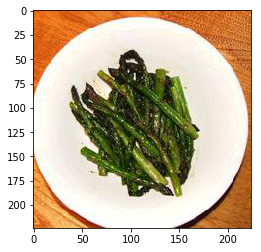

In [14]:
test_img_path = 'food_images/cid11_max2048/6/2294.jpg'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [15]:
# Run this cell if you don't have a vgg graph built
with tf.Session() as sess:
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3], name='input')
    vgg = vgg16.Vgg16()
    vgg.build(input_)

/home/aleksas/labs/food_nutrition_classifier_tf/model/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s


In [16]:
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))

    feed_dict = {input_: img}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

In [17]:
saver = tf.train.Saver()
with tf.Session() as sess:         
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    graph = tf.get_default_graph() 
    
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))
    
    image_buffer_input = graph.get_tensor_by_name('input:0')
    
    feed_dict = {image_buffer_input: img}
    prediction = sess.run(predicted, feed_dict=feed_dict).squeeze()

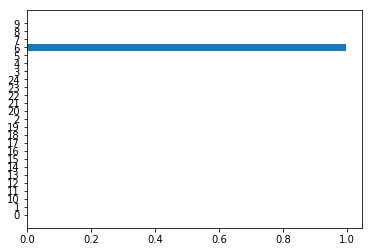

In [18]:
plt.barh(np.arange(len(lb.classes_)), prediction)
_ = plt.yticks(np.arange(len(lb.classes_)), lb.classes_)

In [19]:

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    predictions = sess.run(predicted, feed_dict=feed)

In [20]:
print (predictions.shape)
print(labels[test_idx])
print(np.argmax(test_y, 1).shape)

(4791, 25)
['7' '14' '2' ..., '12' '11' '10']
(4791,)


Normalized confusion matrix


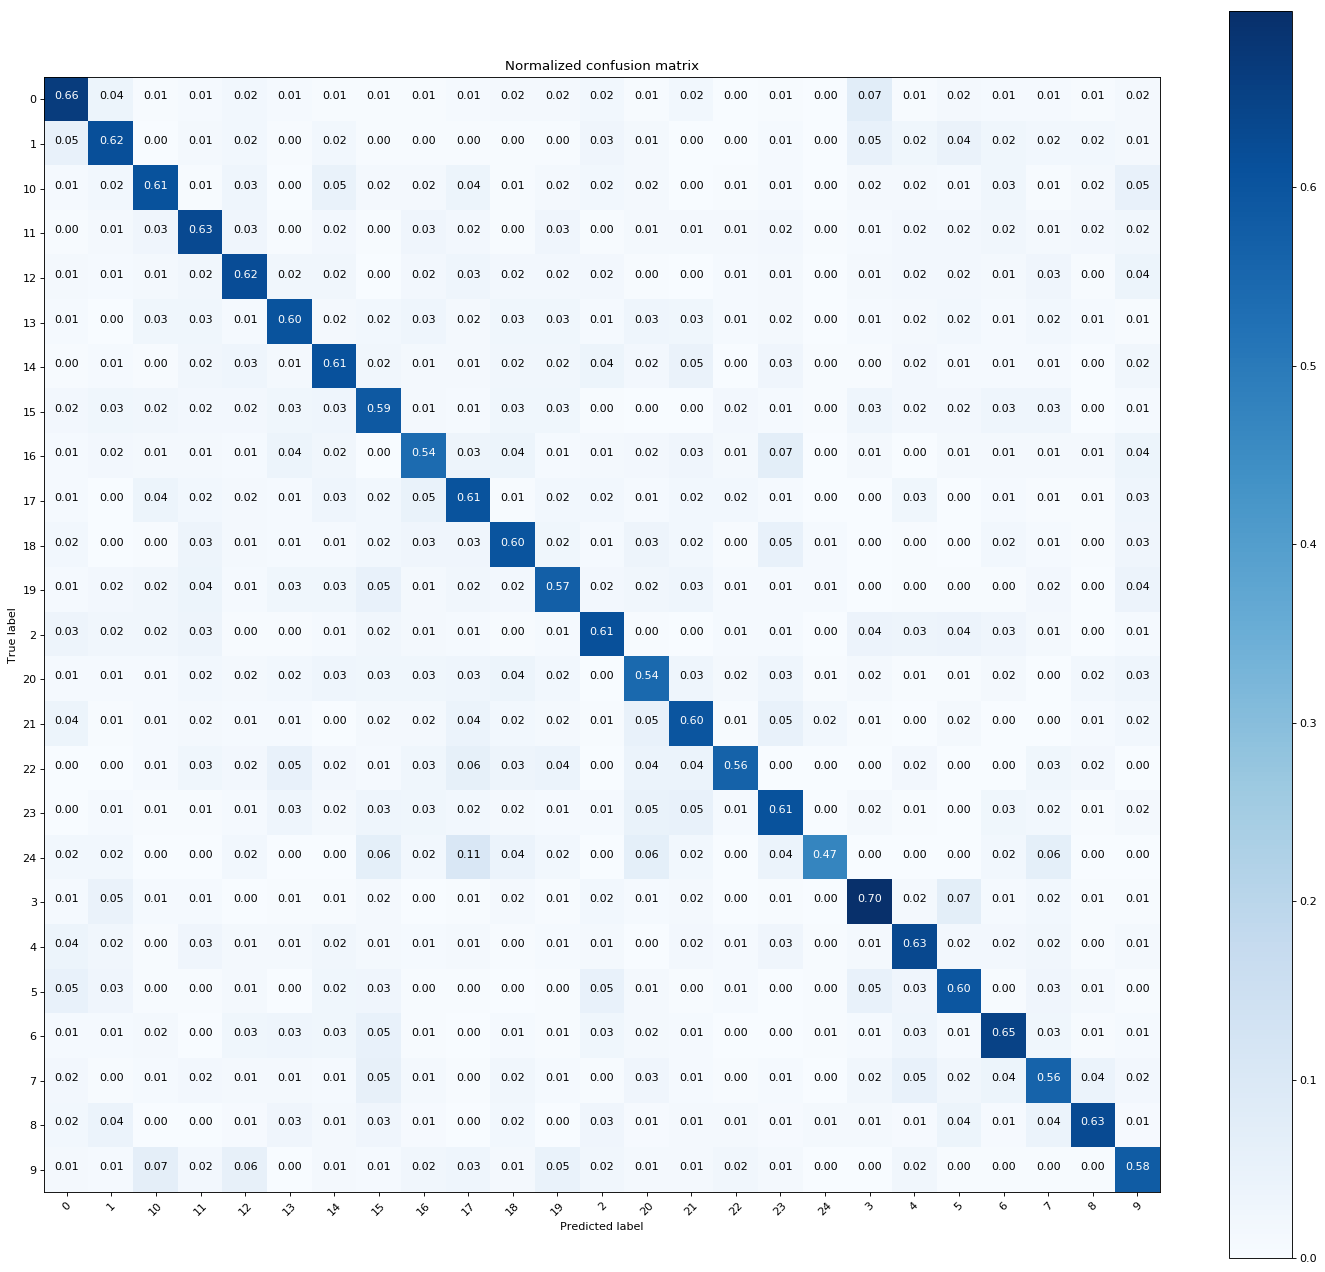

In [21]:
#Ref: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(test_y, 1), np.argmax(predictions, 1))
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plot_confusion_matrix(cnf_matrix, classes=lb.classes_, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Save graph

In [22]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    #tf.train.write_graph(sess.graph_def, "./", "vgg16_food_transfer_learning.pb", False)
    output_node_names = ['final_result', "final_training_ops/BiasAdd"]
    
    output_graph_def = tf.graph_util.convert_variables_to_constants(
        sess, # The session is used to retrieve the weights
        tf.get_default_graph().as_graph_def(), # The graph_def is used to retrieve the nodes 
        output_node_names # The output node names are used to select the usefull nodes
    ) 

    # Finally we serialize and dump the output graph to the filesystem
    with tf.gfile.GFile("vgg16_food_transfer_learning.pb", "wb") as f:
        f.write(output_graph_def.SerializeToString())
    print("%d ops in the final graph." % len(output_graph_def.node))


INFO:tensorflow:Froze 4 variables.
Converted 4 variables to const ops.
104 ops in the final graph.
